# Продвинутое глубокое обучение и обучение с подкреплением: ДЗ №2

**Булаев Владимир, группа DS-32**

Примечание:
- Для решения всех проблем с отображением выложил файл на nbviewer
- Ссылка на оригинальный файл в репозитории: https://github.com/bulaevvi/Advanced-ML/blob/main/AdvancedRL_DL_HW2.ipynb

## Содержание: <a class="anchor" id="zero-bullet"></a>
* [Часть I. Крестики-нолики при помощи Q-обучения](#I)
    * [1. Табличное Q-обучение для доски 3х3](#1)
    * [2. Табличное Q-обучение для доски 4х4](#2)
* [Часть II: добавим нейронных сетей](#II)
    * [3. DQN](#3)
    * [4. Double/dueling DQN](#4)
* [Часть III: расширим и углубим поиск](#III)
    * [5. Rollouts](#5)
    * [6. MCTS](#6)

In [2]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random, copy
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle
from tqdm.notebook import tqdm
from IPython.display import clear_output

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple, defaultdict
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

figsize = (12, 6)

C:\Users\vova\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


Реализация окружения

In [30]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [31]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [32]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
#     cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [33]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

## Часть I. Крестики-нолики при помощи Q-обучения <a class="anchor" id="I"></a>  

**Описание задачи:** 
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.  

[К содержанию](#zero-bullet) 

### 1. Табличное Q-обучение для доски 3х3 <a class="anchor" id="1"></a>  

Условие задачи: *Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.*

In [6]:
def Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.1, gamma=0.9):
    env.reset()
    current_state = env.getHash()
    done = False        
    s, a = current_state, get_pi(current_state) if np.random.rand() > epsilon else np.random.randint(nA)
    for _ in range(1000):
        observation, reward, done, info = env.step(a)
        if (env.curTurn == 1) and (reward != -10):
            reward = -reward
        s_prime, a_prime = observation[0], get_pi(observation[0]) if np.random.rand() > epsilon else np.random.randint(nA)
        current_Q = get_Q(s)
        Q_prime = get_Q(s_prime)
        
        t = Q[s][a] + alpha * (reward + gamma * np.max( Q_prime ) - Q[s][a])
        q_current = []
        for i in range(a):
            q_current.append(Q[s][i])
        q_current.append(t)
        for i in range(a+1, len(Q[s])):
            q_current.append(Q[s][i])

        Q.update({s:q_current})
        s, a = s_prime, a_prime
        if done:
            break
            
def get_random_Q(env):
    nA = env.action_space.n
    Q = np.random.random(size=(nS, nA))
    Q[final_states, :] = 0.0
    return Q

def get_Q(board_hash):
        if board_hash in Q:
            qvals = Q[board_hash]
        else:
            qvals = np.full(N_COLS*N_ROWS, 0)
            Q[board_hash] = qvals
        return qvals
    
def get_pi(board_hash):
        qvals = get_Q(board_hash)
        return np.argmax(qvals)
    
def compute_policy_by_Q(Q, pi, gamma=1.0):
    for state in Q:
        pi.update({state: np.argmax(Q[state])})
    return pi

In [7]:
def get_one_move(env, pi, s, actions, random=False):
    if random:
        act = np.random.randint(len(actions))
        return env.int_from_action(actions[act])
    else:
        return get_pi(s)

In [8]:
def test_game(env, pi1, pi2, random_crosses=False, random_naughts=True):
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_one_move(env, pi1, s, actions, random=random_crosses)
        else:
            a = get_one_move(env, pi2, s, actions, random=random_naughts)
        observation, reward, done, info = env.step(a)
    return reward

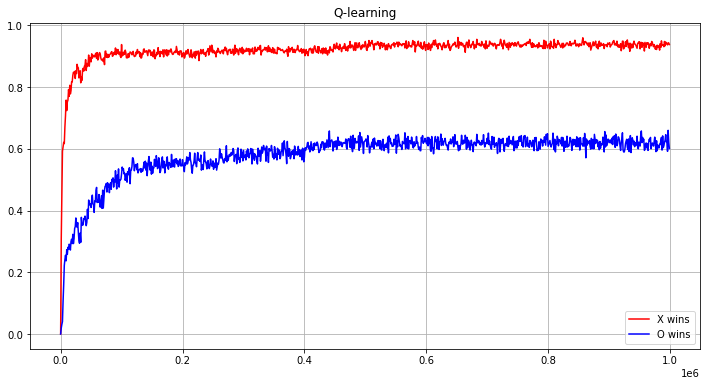

In [9]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
total_episodes = 1_000_000
test_episodes = 1_000
gamma = 0.8

Q_hist_Qlearn = [ ]
Q, pi = {}, {}
nA = N_COLS * N_ROWS
crosses_wins, crosses_draw, naughts_wins, naughts_draw  = [], [], [], []
episodes = []

for n in range(total_episodes):
    Q_learning_episode(env, pi, Q, alpha=0.5, epsilon=0.05, gamma=gamma)
    Q_hist_Qlearn.append(np.copy(Q))
    if (n % 1000 == 0):
        crosses_wins_counter, naughts_wins_counter, crosses_draw_counter, naughts_draw_counter = 0, 0, 0, 0
        for k in range(test_episodes):
            cross = test_game(env, pi, None, random_crosses=False, random_naughts=True)
            if cross == 1:
                crosses_wins_counter +=1 
            elif cross == 0:
                crosses_draw_counter +=1
                
            naughts = test_game(env, None, pi, random_crosses=True, random_naughts=False)
            if naughts == -1:
                naughts_wins_counter +=1 
            elif naughts == 0:
                naughts_draw_counter +=1 
        crosses_wins.append(crosses_wins_counter/test_episodes)
        naughts_wins.append(naughts_wins_counter/test_episodes)
        episodes.append(n)
        
        clear_output(True)
        plt.figure(figsize = figsize)
        plt.grid()
        plt.plot(episodes, crosses_wins, 'r', label='X wins')
        plt.plot(episodes, naughts_wins, 'b', label='O wins')
        plt.title('Q-learning')
        plt.legend()
        plt.show()

env.close()

[К содержанию](#zero-bullet) 

### 2. Табличное Q-обучение для доски 4х4 <a class="anchor" id="2"></a>

Условие задачи: *Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.*  

Disclaimer: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно - но покажите, что со временем что-то всё-таки улучшается.

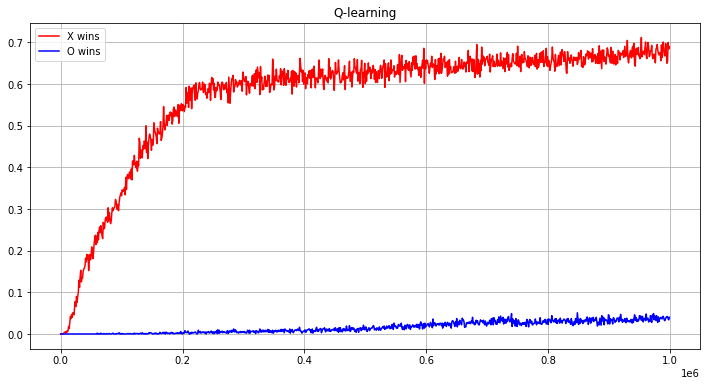

In [10]:
N_ROWS, N_COLS, N_WIN = 4, 4, 4
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
total_episodes = 1_000_000
test_episodes = 1000
gamma = 0.8

Q_hist_Qlearn = [ ]
Q, pi = {}, {}
nA = N_COLS * N_ROWS
crosses_wins, crosses_draw, naughts_wins, naughts_draw  = [], [], [], []
episodes = []

for n in range(total_episodes):
    Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.05, gamma=gamma)
    Q_hist_Qlearn.append(np.copy(Q))
    if (n % 1000 == 0):
        crosses_wins_counter, naughts_wins_counter, crosses_draw_counter, naughts_draw_counter = 0, 0, 0, 0

        for k in range(test_episodes):
            cross = test_game(env, pi, None, random_crosses=False, random_naughts=True)
            if cross == 1:
                crosses_wins_counter +=1 
            elif cross == 0:
                crosses_draw_counter +=1
                
            naughts = test_game(env, None, pi, random_crosses=True, random_naughts=False)
            if naughts == -1:
                naughts_wins_counter +=1 
            elif naughts == 0:
                naughts_draw_counter +=1 
            
        crosses_wins.append(crosses_wins_counter/test_episodes)
        naughts_wins.append(naughts_wins_counter/test_episodes)
        episodes.append(n)
        
        clear_output(True)
        plt.figure(figsize = figsize)
        plt.grid()
        plt.plot(episodes, crosses_wins, 'r', label='X wins')
        plt.plot(episodes, naughts_wins, 'b', label='O wins')
        plt.title('Q-learning')
        plt.legend()
        plt.show()

env.close()

[К содержанию](#zero-bullet) 

**Выводы по части I:**  
1) Крестики обучаются быстрее ноликов на обеих досках  
2) На доске 4х4 при прочих равных параметрах агент обучается хуже, чем на доске 3х3, но в целом видна позитивная динамика обучения  

[К содержанию](#zero-bullet) 

## Часть II: добавим нейронных сетей <a class="anchor" id="II"></a>  

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

### 3. DQN <a class="anchor" id="3"></a>  

Условие задачи: *Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.*

In [11]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
def test_game_dqn(env, model1, model2, random_crosses=False, random_naughts=True):
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_one_move_dqn(env, model1, s, israndom=random_crosses)
        else:
            a = get_one_move_dqn(env, model2, s, israndom=random_naughts)
        s, reward, done, info = env.step(a)
    return reward

def get_one_move_dqn(env, model, state, israndom=False):
    '''Делаем ход'''    
    if israndom:
        empty_spaces = env.getEmptySpaces()
        n_sp = random.randrange(len(empty_spaces))
        act = empty_spaces[n_sp][0] * env.n_cols + empty_spaces[n_sp][1]
        return torch.tensor([[act]], dtype=torch.int64)
    else:
        with torch.no_grad():
            state_matrix = [int(state[i]) for i in range(len(state))] + [env.curTurn]
            state_matrix = torch.tensor([state_matrix], dtype=torch.float32)
            t = model(state_matrix).data.max(1)[1]
            return t.view(1, 1)

In [3]:
class Network(nn.Module):
    def __init__(self, num_channels=120):
        nn.Module.__init__(self)
        self.conv = nn.Conv2d(3, num_channels*2, 3)
        self.l1 = nn.Linear(num_channels*2, num_channels)
        self.l2 = nn.Linear(num_channels, 9)
    
    def forward(self, x):
        x = F.relu(self.conv(x))
        x = F.relu(self.l1(torch.flatten(x, start_dim=1)))
        x = self.l2(x)
        return x

In [14]:
class DQN():
    def __init__(self, n_rows, n_cols, n_win):
        self.env = TicTacToe(n_rows, n_cols, n_win)
        self.model = Network(n_rows, n_cols)
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001) # 3x3: 0.001
        
        self.nrows = n_rows
        self.ncols = n_cols
        self.n_win = n_win
        
        self.gamma = 0.8
        self.steps_done = 0
        self.episode_durations = []
        self.batch_size = 128 # 3x3: 128
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 2000
        self.num_step = 0
        
    def select_greedy_action(self, state):
        t = self.model(state).data.max(1)[1]
        return t.view(1, 1)
    
    def state_to_matrix(self, state):
        state_matrix = [int(state[i]) for i in range(len(state))]
        return state_matrix+[self.env.curTurn]
    
    def select_action(self, state):
        empty_spaces = self.env.getEmptySpaces()
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            n_sp = random.randrange(len(empty_spaces))
            act = empty_spaces[n_sp][0] * self.ncols + empty_spaces[n_sp][1]
            return torch.tensor([[act]], dtype=torch.int64)
        
    def select_random_action(self, state):
        empty_spaces = self.env.getEmptySpaces()
        n_sp = random.randrange(len(empty_spaces))
        act = empty_spaces[n_sp][0] * self.ncols + empty_spaces[n_sp][1]
        return torch.tensor([[act]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False):
        self.env.reset()
        state = self.env.getState()
        num_step = 0
        actions = []
        losses = []
        while True:
            state_tensor = torch.tensor([self.state_to_matrix(state[0])], dtype=torch.float32)
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state_tensor)
                else:
                    action = self.select_action(state_tensor)
            next_state, reward, done, _ = self.env.step(action.numpy()[0][0])
            if (self.env.curTurn == 1) and (reward == -1):
                reward = -reward
            
            next_state_tensor = torch.tensor([self.state_to_matrix(next_state[0])], dtype=torch.float32) 
            transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            actions.append(action)
            self.memory.store(transition)

            if do_learning:
                losses.append(self.learn())

            state = next_state
            num_step += 1

            if done:
                return reward, losses
                #break

    def learn(self):
        if len(self.memory) < self.batch_size:
            return
        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
        batch_state = Variable(torch.cat(batch_state), requires_grad=True)
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward), requires_grad=True)
        batch_next_state = Variable(torch.cat(batch_next_state), requires_grad=True)

        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)
        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

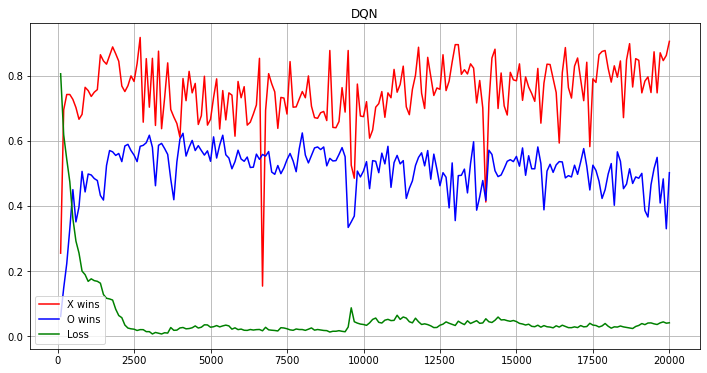

In [15]:
dqn = DQN(3, 3, 3)
total_episodes = 20_000
test_episodes = 1000
rewards = []
losses = []
reward = []
loss = []
counter = []
episodes = []
crosses_wins, crosses_draw, naughts_wins, naughts_draw  = [], [], [], []
NoneType = type(None)

for e in range(total_episodes):
    reward1, loss1 = dqn.run_episode(e)
    for i in loss1:
        if type(i) is not NoneType:
            loss += [i]
    reward += [reward1]
    
    if (e+1) % 100 == 0:
        counter.append(e)
        losses.append(np.mean(loss))
        loss = []
        reward = []
        crosses_wins_counter, naughts_wins_counter = 0, 0
        for k in range(test_episodes):
            cross = test_game_dqn(dqn.env, dqn.model, None, random_crosses=False, random_naughts=True)
            if cross == 1:
                crosses_wins_counter +=1 
                
            naughts = test_game_dqn(dqn.env, None, dqn.model, random_crosses=True, random_naughts=False)
            if naughts == -1:
                naughts_wins_counter +=1 
                
        episodes.append(e)
        crosses_wins.append(crosses_wins_counter/test_episodes)
        naughts_wins.append(naughts_wins_counter/test_episodes)
                
        clear_output(True)
        plt.figure(figsize = figsize)
        plt.grid()
        plt.plot(episodes, crosses_wins, 'r', label='X wins')
        plt.plot(episodes, naughts_wins, 'b', label='O wins')
        plt.plot(counter, losses, 'g', label='Loss')
        plt.title('DQN')
        plt.legend()
        plt.show()

[К содержанию](#zero-bullet) 
### 4. Double/dueling DQN <a class="anchor" id="4"></a>

Условие задачи: *Реализуйте Double DQN и/или Dueling DQN.*

In [16]:
class DoubleDQN():
    def __init__(self, n_rows, n_cols, n_win, lr = 0.0001):
        self.env = TicTacToe(n_rows, n_cols, n_win)
        self.model = Network(n_rows, n_cols)
        self.target_model = Network(n_rows, n_cols)
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), lr) 
        
        self.nrows = n_rows
        self.ncols = n_cols
        self.n_win = n_win
        
        self.gamma = 0.7
        self.steps_done = 0
        self.episode_durations = []
        self.batch_size = 128 
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 2000
        self.target_update =500
        self.num_step = 0
        
    def select_greedy_action(self, state):
        t = self.model(state).data.max(1)[1]
        return t.view(1, 1)
    
    def state_to_matrix(self, state):
        state_matrix = [int(state[i]) for i in range(len(state))]
        return state_matrix+[self.env.curTurn]
    
    def select_action(self, state):
        empty_spaces = self.env.getEmptySpaces()
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state)
        else:
            n_sp = random.randrange(len(empty_spaces))
            act = empty_spaces[n_sp][0] * self.ncols + empty_spaces[n_sp][1]
            return torch.tensor([[act]], dtype=torch.int64)
        
    def select_random_action(self, state):
        empty_spaces = self.env.getEmptySpaces()
        n_sp = random.randrange(len(empty_spaces))
        act = empty_spaces[n_sp][0] * self.ncols + empty_spaces[n_sp][1]
        return torch.tensor([[act]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True, greedy=False):
        self.env.reset()
        if self.num_step == 0:
            self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()
        state = self.env.getState()
        actions = []
        losses = []
        while True:
            self.num_step += 1
            state_tensor = torch.tensor([self.state_to_matrix(state[0])], dtype=torch.float32)
            with torch.no_grad():
                if greedy:
                    action = self.select_greedy_action(state_tensor)
                else:
                    action = self.select_action(state_tensor)
            next_state, reward, done, _ = self.env.step(action.numpy()[0][0])
            if (reward != -10) and(self.env.curTurn == 1):
                reward = -reward
            
            next_state_tensor = torch.tensor([self.state_to_matrix(next_state[0])], dtype=torch.float32) 
            transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            actions.append(action)
            self.memory.store(transition)

            if do_learning:
                losses.append(self.learn())
            state = next_state    
            
            if self.num_step % self.target_update == 0:
                    self.target_model.load_state_dict(self.model.state_dict())

            if done:
                return reward, losses
                #break
            
                
    def learn(self):
        if len(self.memory) < self.batch_size:
            return
        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
        batch_state = Variable(torch.cat(batch_state), requires_grad=True)
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward), requires_grad=True)
        batch_next_state = Variable(torch.cat(batch_next_state), requires_grad=True)
        # считаем значения функции Q
        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])
        Q_target = self.target_model(batch_state).gather(1, batch_action).reshape([self.batch_size])
        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)
        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

Опробуем DoubleDQN на доске 3х3

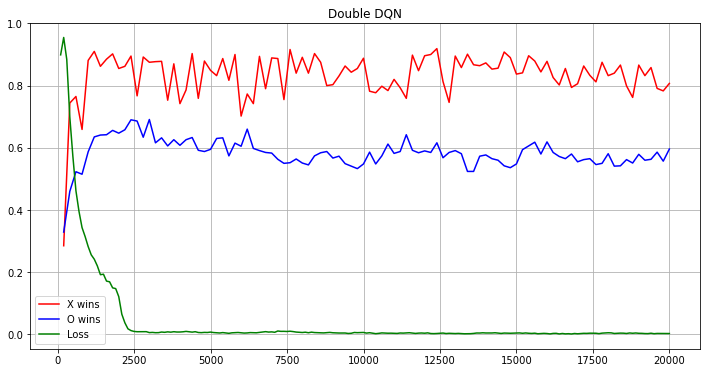

In [17]:
ddqn = DoubleDQN(3, 3, 3)
test_episodes = 1000
total_episodes = 20_000
rewards = []
losses = []
reward = []
loss = []
counter = []
episodes = []
crosses_wins, crosses_draw, naughts_wins, naughts_draw  = [], [], [], []
NoneType = type(None)

for e in range(total_episodes):
    reward1, loss1 = ddqn.run_episode(e)
    for i in loss1:
        if type(i) is not NoneType:
            loss += [i]
    reward += [reward1]
    if (e+1) % 100 == 0:
        counter.append(e)
        losses.append(np.mean(loss))
        loss = []
        reward = []
    
    if (e+1) % 200 == 0:
        crosses_wins_counter, naughts_wins_counter = 0, 0
        for k in range(test_episodes):
            cross = test_game_dqn(ddqn.env, ddqn.model, None, random_crosses=False, random_naughts=True)
            if cross == 1:
                crosses_wins_counter +=1 
            naughts = test_game_dqn(ddqn.env, None, ddqn.model, random_crosses=True, random_naughts=False)
            if naughts == -1:
                naughts_wins_counter +=1 
                
        episodes.append(e)
        crosses_wins.append(crosses_wins_counter/test_episodes)
        naughts_wins.append(naughts_wins_counter/test_episodes)
        clear_output(True)
        plt.figure(figsize = figsize)
        plt.grid()
        plt.plot(episodes, crosses_wins, 'r', label='X wins')
        plt.plot(episodes, naughts_wins, 'b', label='O wins')
        plt.plot(counter, losses, 'g', label='Loss')
        plt.title('Double DQN')
        plt.legend()
        plt.show()

Опробуем DoubleDQN на доске 4х4

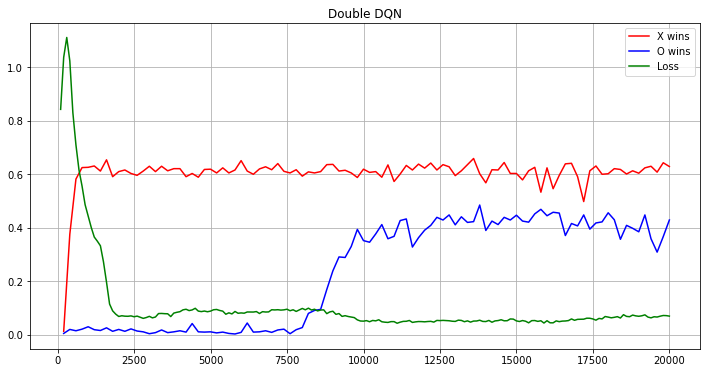

In [19]:
ddqn = DoubleDQN(4, 4, 4, 0.001)
total_episodes = 20_000
test_episodes = 1000
rewards = []
losses = []
reward = []
loss = []
counter = []
episodes = []
crosses_wins, crosses_draw, naughts_wins, naughts_draw  = [], [], [], []

NoneType = type(None)
for e in range(total_episodes):
    reward1, loss1 = ddqn.run_episode(e)
    for i in loss1:
        if type(i) is not NoneType:
            loss += [i]
    reward += [reward1]
    
    if (e+1) % 100 == 0:
        counter.append(e)
        losses.append(np.mean(loss))
        loss = []
        reward = []
    
    if (e+1) % 200 == 0:
        crosses_wins_counter, naughts_wins_counter = 0, 0
        for k in range(test_episodes):
            cross = test_game_dqn(ddqn.env, ddqn.model, None, random_crosses=False, random_naughts=True)
            if cross == 1:
                crosses_wins_counter +=1 
            naughts = test_game_dqn(ddqn.env, None, ddqn.model, random_crosses=True, random_naughts=False)
            if naughts == -1:
                naughts_wins_counter +=1 
                
        episodes.append(e)
        crosses_wins.append(crosses_wins_counter/test_episodes)
        naughts_wins.append(naughts_wins_counter/test_episodes)
        clear_output(True)
        plt.figure(figsize = figsize)
        plt.grid()
        plt.plot(episodes, crosses_wins, 'r', label='X wins')
        plt.plot(episodes, naughts_wins, 'b', label='O wins')
        plt.plot(counter, losses, 'g', label='Loss')
        plt.title('Double DQN')
        plt.legend()
        plt.show()

**Выводы по части II:**  
1) DQN гораздо быстрее обучается по сравнению с табличным Q-обучением: для DQN потребовалось около 3-4 тыс. итераций для выхода на плато на доске 3х3 (Q-learning потребовалось несколько сот тысяч итераций для этого).  
2) Аналогичная ситуация с доской 4х4: даже после 1 млн. итераций Q-learning полноценно ны вышло на плато, в то же время нейросетевому алгоритму потребовалось около 10 тыс. итераций.  
3) Обучение по методу Double DQN носит более стабильный характер по сранению с традиционным DQN.  
4) В целом Q-learning дает более лучшие результаты в плане умения агента выигрывать, и это вполне объяснимо: в DQN мы осуществляем приближение настоящей Q-функции. Однако на большой доске Q-обучение просто невозможно осуществить, и в такой ситуации DQN сильно выручает.

[К содержанию](#zero-bullet) 

## Часть III: расширим и углубим поиск <a class="anchor" id="III"></a>   

Условие задачи: *Крестики-нолики - это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS - заодно фактически получится и упражнение на многоруких бандитов.*

### 5. Rollouts <a class="anchor" id="5"></a>  

Условие задачи: *Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).*

In [20]:
def do_rollouts(env, s, cur_turn, pi, num_episodes):
    summ_reward = 0
    if cur_turn == -1:
        pi1 = copy.deepcopy(pi)
        pi2 = None
        random_naughts = True
        random_crosses = False
    else:
        pi1 = None
        pi2 = copy.deepcopy(pi)
        random_crosses = True
        random_naughts = False
    for i in range(num_episodes):
        current_env = copy.deepcopy(env)
        done = False
        while not done:
            s, actions = current_env.getHash(), current_env.getEmptySpaces()
            if current_env.curTurn == 1:
                a = get_one_move(current_env, pi1, s, actions, random=random_crosses)
            else:
                a = get_one_move(current_env, pi2, s, actions, random=random_naughts)
            s, reward, done, info = current_env.step(a)
            if current_env.curTurn == 1 and reward != -10:
                reward = -reward
            summ_reward += reward
    return summ_reward/num_episodes

In [21]:
def test_game_with_rollouts(env, pi1, pi2, random_crosses=False, random_naughts=True):
    done = False
    env.reset()
    if random_naughts: 
        while not done:
            s, actions = env.getHash(), env.getEmptySpaces()
            if env.curTurn == 1: 
                rollout_results = {}
                current_env = copy.deepcopy(env)
                for act in actions:
                    curr_a = current_env.int_from_action(act)
                    s, reward, done, info = current_env.step(curr_a)
                    if not(done):
                        rollout_result = do_rollouts(current_env, s, pi1, current_env.curTurn, 100)
                    else:
                        rollout_result = reward
                    rollout_results.update({curr_a:rollout_result})
                a = max(rollout_results, key=lambda k: rollout_results[k])
                pi.update({s[0]:a})
            else: 
                a = get_one_move(env, pi2, s, actions, random=random_naughts)
            observation, reward, done, info = env.step(a)
    else: 
        while not done:
            s, actions = env.getHash(), env.getEmptySpaces()
            if env.curTurn == -1:
                rollout_results = {}
                current_env = copy.deepcopy(env)
                for act in actions:
                    curr_a = current_env.int_from_action(act)
                    s, reward, done, info = current_env.step(curr_a)
                    if not(done):
                        rollout_result = do_rollouts(current_env, s, pi2, current_env.curTurn, 100)
                    else:
                        rollout_result = reward if reward == -10 else -reward
                    rollout_results.update({curr_a:rollout_result})
                a = max(rollout_results, key=lambda k: rollout_results[k])
                pi.update({s[0]:a})
            else:
                a = get_one_move(env, pi1, s, actions, random=random_crosses)
            observation, reward, done, info = env.step(a)
    return reward

Реализуем rollout с использованием стратегий из части I. Для этого обучим Q-функции с помощью Q-learning на малом количестве эпизодов:

In [27]:
total_episodes = 5_000
test_episodes = 1000
gamma = 0.8
N_ROWS, N_COLS, N_WIN = 4, 4, 4
Q_hist_Qlearn = [ ]
Q = {}
pi = {}

env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
episodes = []
for n in range(total_episodes):
    Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.05, gamma=gamma)
    pi = compute_policy_by_Q(Q, pi)
    Q_hist_Qlearn.append(np.copy(Q))
env.close()
pi = compute_policy_by_Q(Q, pi)

Протестируем rollouts на стратегии, обученной на малом количестве итераций

In [28]:
rollout_result_crosses, result_crosses, rollout_result_naughts, result_naughts = 0, 0, 0, 0
total_episodes = 1000
for i in range(total_episodes):
    if test_game_with_rollouts(env, pi, None, random_crosses=False, random_naughts=True) == 1:
        rollout_result_crosses += 1
    if test_game(env, pi, None, random_crosses=False, random_naughts=True) == 1:
        result_crosses += 1
    if test_game_with_rollouts(env, None, pi, random_crosses=True, random_naughts=False) == -1:
        rollout_result_naughts += 1
    if test_game(env,  None, pi, random_crosses=True, random_naughts=False) == -1:
        result_naughts += 1
    
print("X wins %d games with rollouts and %d without rollouts out of %d games" %(rollout_result_crosses, result_crosses, total_episodes))
print("O wins %d games with rollouts and %d without rollouts out of %d games" %(rollout_result_naughts, result_naughts, total_episodes))

X wins 895 games with rollouts and 0 without rollouts out of 1000 games
O wins 670 games with rollouts and 0 without rollouts out of 1000 games


[К содержанию](#zero-bullet) 

### 6. MCTS <a class="anchor" id="6"></a>  

Условие задачи: *Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.*  

Опробуем "чистый" MCTS.

In [39]:
class MCTSPlayer:

    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, n_rollouts=50, player=1, c=1):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win
        self.n_rollouts = n_rollouts
        self.player = player
        self.state_nodes = {}
        self.id_nodes = {}
        self.ids = 0
        self.c = c

    def get_action(self, state, actions):
        if state in self.state_nodes:
            node = self.state_nodes[state]
        else:
            node = {'id': self.ids,
                    'a': None,
                    'w': 0,
                    'n': 0,
                    'pn': None,
                    's': state,
                    'c': [],
                    'p': self.player}
            self.ids += 1
            self.state_nodes[state] = node
            self.id_nodes[node['id']] = node
        self.mcts(node)
        best_node = node['c'][0]
        for cn in node['c']:
            if cn['w']/(cn['n'] + 1e-4) < best_node['w']/(best_node['n'] + 1e-4):
                best_node = cn
        for i, a in enumerate(actions):
            if a[0] == best_node['a'][0] and a[1] == best_node['a'][1] :
                return i

    def mcts(self, r_node):
        for i in range(self.n_rollouts):
            leaf = self.selection(r_node)
            cnode = self.expansion(leaf)
            winner = self.simulation(cnode)
            self.backpropagation(cnode, winner)

    def backpropagation(self, node, winner):
        while node is not None:
            node['n'] += 1
            if winner == node['p']:
                node['w'] += 1
            node = node['pn']

    def simulation(self, node):
        board = self.state_to_board(node['s'])
        cur_turn = node['p']
        while True:
            winner = self.is_terminal_state(board, -cur_turn)
            if winner is not None:
                return winner
            a = random.choice(self.get_empty_spaces(board))
            board[a[0]][a[1]] = cur_turn
            cur_turn = -cur_turn

    def selection(self, node):
        while len(node['c']) > 0:
            max_v = node['c'][0]['w']/(node['c'][0]['n'] + 1e-4) + self.c * np.sqrt(np.log(node['n'])/(node['c'][0]['n'] + 1e-4))
            max_node = node['c'][0]
            for cn in node['c']:
                v = cn['w'] / (cn['n'] + 1e-4) + self.c * np.sqrt(np.log(node['n']) / (cn['n'] + 1e-4))
                if max_v < v:
                    max_node = cn
                    max_v = v
            node = max_node
        return node

    def expansion(self, node):
        winner = self.is_terminal_node(node)
        if winner is None :
            for a in self.get_empty_spaces(self.state_to_board(node['s'])):
                nstate = self.apply_action(node['s'], a, node['p'])
                cnode = {'id': self.ids,
                         'a': a,
                         'w': 0,
                         'n': 0,
                         'pn': node,
                         's': nstate,
                         'c': [],
                         'p': -node['p']}
                self.ids += 1
                self.state_nodes[nstate] = cnode
                self.id_nodes[node['id']] = cnode
                node['c'].append(cnode)
            node = random.choice(node['c'])
        return node

    def apply_action(self, state, action, player):
        board = self.state_to_board(state)
        board[action[0]][action[1]] = player
        return ''.join(['%s' % (x + 1) for x in board.reshape(self.n_rows * self.n_cols)])

    def state_to_board(self, state):
        return np.array([int(x) - 1 for x in state]).reshape([self.n_rows, self.n_cols])

    def is_terminal_node(self, node):
        return self.is_terminal_state(self.state_to_board(node['s']), -node['p'])

    def is_terminal_state(self, board, cur_turn):
        cur_marks, cur_p = np.where(board == cur_turn), cur_turn
        for i, j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(board[i:i + self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(board[i, j:j + self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([board[i + k, j + k] == cur_p for k in range(self.n_win)])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win - 1:
                    if np.all(np.array([board[i + k, j - k] == cur_p for k in range(self.n_win)])):
                        win = True
            if win:
                return cur_turn

        if len(self.get_empty_spaces(board)) == 0:
            return 0

        return None

    def get_empty_spaces(self, board):
        res = np.where(board == 0)
        return np.array([(i, j) for i, j in zip(res[0], res[1])])


class RandomPlayer:
    def get_action(self, state, actions, explore=False):
        action_idx = random.randint(0, len(actions) - 1)
        return action_idx
    
    def learn_episode(self, steps, reward):
        pass

def run_episode(env, player1, player2):
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            action_idx = player1.get_action(s, actions)
        else:
            action_idx = player2.get_action(s, actions)
        _, reward, done, _ = env.step(actions[action_idx])
    return reward

Посмотрим MCTS на доске 3х3

In [66]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
total_episodes = 1000
rewards = []
player1 = MCTSPlayer(n_rows=3, n_cols=3, n_win=3)
player2 = RandomPlayer()
for i in range(total_episodes):
    rewards.append(run_episode(env, player1, player2))
print("X wins %d games with MCTS out of %d games" %(sum([1 for x in rewards if x == 1]), total_episodes))

X wins 908 games with MCTS out of 1000 games


In [46]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
total_episodes = 1000
rewards = []
player1 = RandomPlayer()
player2 = MCTSPlayer(n_rows=3, n_cols=3, n_win=3)
for i in range(total_episodes):
    rewards.append(run_episode(env, player1, player2))
print("O wins %d games with MCTS out of %d games" %(sum([1 for x in rewards if x == 1]), total_episodes))

O wins 769 games with MCTS out of 1000 games


Посмотрим MCTS на доске 4х4

In [71]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
total_episodes = 100
rewards = []
player1 = MCTSPlayer(n_rows=4, n_cols=4, n_win=4)
player2 = RandomPlayer()
for i in range(total_episodes):
    rewards.append(run_episode(env, player1, player2))
print("X wins %d games with MCTS out of %d games" %(sum([1 for x in rewards if x == 1]), total_episodes))

X wins 60 games with MCTS out of 100 games


In [80]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
total_episodes = 100
rewards = []
player1 = RandomPlayer()
player2 = MCTSPlayer(n_rows=4, n_cols=4, n_win=4)
for i in range(total_episodes):
    rewards.append(run_episode(env, player1, player2))
print("O wins %d games with MCTS out of %d games" %(sum([1 for x in rewards if x == 1]), total_episodes))

O wins 16 games with MCTS out of 100 games


**Выводы по части III:**  
1) Даже на сравнительно слабо обученной стратегии (5 тыс. итераций) rollout позволяет добиться очень хороших результатов: около 0.895 для крестиков и около 0.67 для ноликов.  
2) Если не использовать rollout, то подобный результат для крестиков достигается на 100 тыс., для ноликов - 400 тыс. итераций обучения.  
3) Для MCTS результат еще лучше: 0.908 для крестиков и 0.769 для ноликов (для доски 3х3). Таким образом, MCTS показывает лучший результат на доске 3х3.    
4) Агент MCTS играет гораздо дольше по сравнению с rollout.  
5) Для доски 4х4 "чистого" MCTS уже недостаточно, чтобы быть безоговорочным лидером: 0.60 для крестиков и 0.16 для ноликов. Для крестиков результат сопоставим с Double DQN, а вот для ноликов Double DQN показывал более лучший результат - в районе 0.4.  
6) Для доски 4х4 пришлось уменьшить количество игр с 1000 до 100, т.к. MCTS работает существенно дольше. Для полноценного проведения экспериментов необходимы существенные вычислительные мощности.  

[К содержанию](#zero-bullet) 